# Práctico Clustering

El dataset de [GuessWhat?!](https://arxiv.org/abs/1611.08481) es un dataset de diálogos visuales referenciales.
Está compuesto de diálogos contextualizados en imágenes basados en un juego de adivinar un objeto. Todas las preguntas son del estilo "Sí/No".

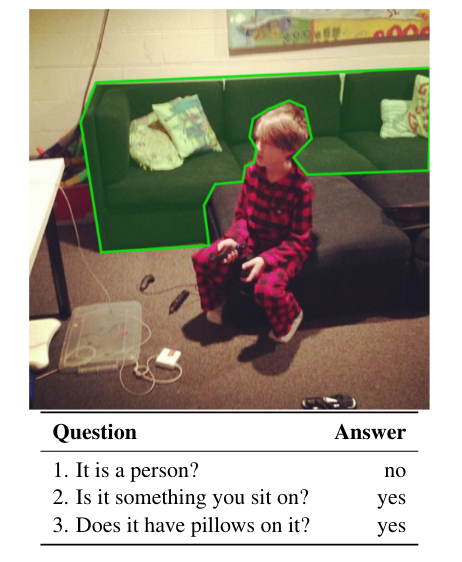

En este práctico voy a caracterizar las palabras usadas en distintas preguntas. El dataset se puede obtener [aquí](https://drive.google.com/file/d/1JiJIV_Ve65SHriU8veTtLVWmlM-Nu6pi/view?usp=sharing).

In [1]:
# Stanza
import stanza

# Numpy
import numpy as np

# WordCloud
from wordcloud import WordCloud

# Sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# PyPlot
import matplotlib.pyplot as plt

# Utils
import math
import jsonlines
import gzip
import os
import stanza
import numpy as np
import json
from tqdm import tqdm

## 1) Preprocesamiento de datos

Para mantener las cosas simples y que entren en memoria, trabajé con el conjunto de validación.

In [ ]:
rawdata = jsonlines.Reader(gzip.open('guesswhat.valid.jsonl.gz'))
questions = ""
for game in rawdata:
    for qa in game['qas']:
        questions += qa['question'] + '\n'
        
fname = 'guesswhat.valid.raw.txt'
if not os.path.exists(fname):
    with open(fname, 'w') as fl:
        fl.write(questions)

Utilizo [Stanza](https://stanfordnlp.github.io/stanza/) para procesar el texto con un pipeline de PLN.

In [ ]:
stanza.download('en')
nlp = stanza.Pipeline('en')

In [ ]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')
questions = np.asarray(questions)

Stanza puede usar una GPU si tiene disponible. Uso un batch de 256 preguntas para aprovechar al máximo cada forward pass.

In [ ]:
# Tamaño del batch
batch_size = 256

complete_doc = []
total_batches = math.ceil(len(questions)/batch_size)
for b in tqdm(range(total_batches)):
    # I actually forgot how to batch correctly. So... here it is.
    # Please forgive me.
    if b == total_batches -1:
        sample = questions[b*batch_size:] 
    else:
        sample = questions[b*batch_size: (b+1)*batch_size] 

    # Formar batch para Stanza separado por \n\n
    allqs = ''
    for q in sample:
        allqs += q
        allqs += '\n\n'
    allqs = allqs.lower().strip()

    # NLP(allqs)
    doc = nlp(allqs)
    complete_doc += doc.to_dict()
    
complete_doc = stanza.Document(complete_doc)
doc_fname = 'guesswhat.valid.doc.json'
with open(doc_fname, 'w') as fl:
    json.dump(complete_doc.to_dict(), fl)

## 2) Exploración Manual

Exploré antes un poco los datos para ver bien con qué estoy trabajando.

In [4]:
doc_fname = 'guesswhat.valid.doc.json'
with open(doc_fname, 'r') as fl:
    new_doc = stanza.Document(json.load(fl))

In [5]:
fname = 'guesswhat.valid.raw.txt'
with open(fname) as fl:
    questions = fl.read().split('\n')

Miro la ocurrencia de palabras en el corpus.

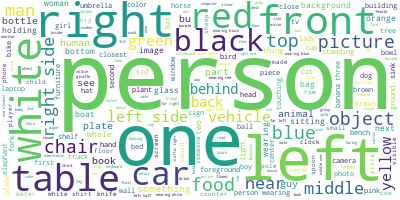

In [6]:
# Join the different processed titles together.
long_string = ','.join(questions)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [7]:
vectorizer = CountVectorizer()
omatrix = vectorizer.fit_transform(questions)

Visualizo las estructuras de datos que generan tanto Scikit Learn como Stanza

In [8]:
print('Count Vectorizer: ----')
print(len(vectorizer.get_feature_names()))
print(omatrix.toarray().shape)

print('Stanza: ----')
print(len(new_doc.sentences))
print(new_doc.num_words)
print(new_doc.num_tokens)

Count Vectorizer: ----
5016
(120319, 5016)
Stanza: ----
120649
705421
705421


Miro las dependencias a nivel oración generadas por Stanza

In [9]:
print('question:' ,' '.join([w.text for w in new_doc.sentences[0].words]))
for (w1, rel, w2) in new_doc.sentences[0].dependencies:
    print('({}, {}, {})'.format(w1.text, rel, w2.text))

question: is it an bear ?
(bear, cop, is)
(bear, nsubj, it)
(bear, det, an)
(ROOT, root, bear)
(bear, punct, ?)


y las dependencias a nivel palabra.

In [10]:
for w in new_doc.sentences[0].words:
    print(w.id, w.text, '\t: (', w.deprel, w.head, ')')

1 is 	: ( cop 4 )
2 it 	: ( nsubj 4 )
3 an 	: ( det 4 )
4 bear 	: ( root 0 )
5 ? 	: ( punct 4 )


## 3) Experimento con triplas de dependencia

Voy a mantener el vocabulario solo las palabras que hayan sido reconocidas por el CountVectorizer ya que ya remueven stopwords y puntuaciones.

Lo primero es generar un vocabulario y un diccionario de contextos.

In [11]:
vocab = {_w: {'id':i, 'contexts':[], 'occurrence':[]} for i, _w in enumerate(vectorizer.get_feature_names())}
context_vocab = {}

for sent in tqdm(new_doc.sentences):
    words = {word.id:word.text for word in sent.words}
    words[0] = 'ROOT'
    triplets = [(w1.text, rel, w2.text) for (w1, rel, w2) in sent.dependencies]
    for word in sent.words:
        if not (word.text in vocab.keys()):
            continue
        # Compute the dependecy for this word
        # triplets will be (word, word.rel, word.head) as seen above
        dependency = (word.deprel, words[word.head])
        if not (dependency in context_vocab.keys()):
            context_vocab[dependency] = [word.text]
        else:
            context_vocab[dependency].append(word.text)

        if not (dependency in vocab[word.text]["contexts"]):
            vocab[word.text]["contexts"].append(dependency)
            vocab[word.text]["occurrence"].append(1)
        else:
            i = vocab[word.text]["contexts"].index(dependency)
            vocab[word.text]["occurrence"][i] += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120649/120649 [00:13<00:00, 8921.64it/s]


Me quedo con los contextos que ocurren más de 10 veces

In [12]:
context_ocurrence = np.array([len(context_vocab[k]) for k in context_vocab])
keeping = np.where(context_ocurrence > 10)
relevant_context = np.asarray(list(context_vocab.keys()))[keeping]
print("{} contextos relevantes".format(len(relevant_context)))

3257 contextos relevantes


Vectorización por ocurrencias de contextos relevantes.

In [13]:
shape = (len(vocab), len(relevant_context))
feat_matrix = np.zeros(shape)

for w in tqdm(list(vocab.values())):
    i = w['id']
    context = w['contexts']
    ocurrence = w['occurrence']
    for j, dep in enumerate(relevant_context):
        try:
            k = context.index(tuple(dep))
        except ValueError:
            continue
        feat_matrix[i,j] = ocurrence[k]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5016/5016 [01:28<00:00, 56.46it/s]


Se sigue la siguiente lista de pasos:

1. Normalización
2. LSA a 50 dimensiones
3. Clustering a 20 clusters
4. t-SNE para visualización
5. Plot

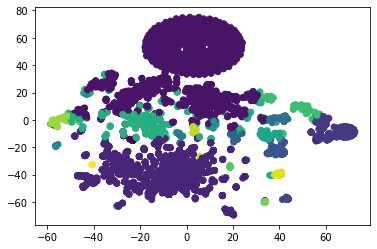

In [14]:
norm_feat_matrix = normalize(feat_matrix)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(norm_feat_matrix)
y_pred = KMeans(n_clusters=20).fit_predict(reduced_feat_matrix)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)

Genero un diccionario inverso para poder mirar las palabras de los clusters

In [15]:
id2word = {vocab[w]['id']:w for w in vocab}

In [16]:
def showing_cluster(clusters, vocab, cluster_id, showing=20):
    showing_words = []
    for idx, c in enumerate(clusters):
        if c == cluster_id:
            showing_words.append(id2word[idx])
        if len(showing_words) == showing:
            break
    cluster_size = np.where(clusters == cluster_id)[0].shape[0]
    print('Cluster {} ({} words):'.format(cluster_id, cluster_size))
    print(showing_words)

In [17]:
for k in range(20):
    showing_cluster(y_pred, vocab, k, showing=50)
    print('-------------\n')

Cluster 0 (13 words):
['cement', 'dump', 'ex', 'fedex', 'ford', 'garbage', 'pepsi', 'pickup', 'schepps', 'staples', 'tow', 'uhaul', 'ups']
-------------

Cluster 1 (2179 words):
['10', '18', '2nd', '3313', '350', '3rd', '4th', '4x4', '5901', '5th', '6th', '7th', '80', '8th', 'abject', 'able', 'aboy', 'ac', 'accessories', 'accessory', 'activia', 'ad', 'add', 'adult', 'adventure', 'aeroplane', 'age', 'agree', 'aha', 'air', 'airborne', 'aircraft', 'airplane', 'airport', 'aisle', 'ajar', 'alarm', 'alcoholic', 'aligned', 'alive', 'all', 'almonds', 'aloe', 'alone', 'amaretto', 'amber', 'ambulance', 'aminal', 'animal', 'animala']
-------------

Cluster 2 (1595 words):
['00', '100', '111', '1418', '150', '154', '165', '20', '248', '29', '334', '34', '377', '42', '45', '50', '50s', '52', '53', '56', '60', '60350', '75', '7c', '9748', '99', '__', 'a64', 'aa', 'above', 'according', 'accordion', 'aceel', 'acer', 'acoustic', 'across', 'action', 'actively', 'actual', 'actually', 'adams', 'adidas', '

### Análisis

Clusters interesantes son:

- **Cluster 0**: nombres de marcas
- **Cluster 1**: parece ser el cluster con mayor presencia de categorías aunque muy mesclada con otras palabras
- **Cluster 3 y 6**: principalmente plurales. Muy usados en preguntas de agrupamiento ("is it one of the bananas?")
- **Cluster 16 y 19**: adjetivos
- **Cluster 17**: posibles meta referencias a la imagen que se está mirando (*picture*, *photo*)
- **Cluster 18**: numerales. Usados principalmente en preguntas de conteo o enumeración

No hay ningún cluster que haya capturado el concepto de categoría o supercategoría a simple vista. Muchas de estas palabras ocurren como la raíz del analizador de Stanza.

## 4) Probando filtrar por más ocurrencias

La idea es ver si pedir una cantidad de ocurrencias mayor permite observar mejor el surgimiento de clusters dedicados a categorías o super categorías.

In [18]:
context_ocurrence = np.array([len(context_vocab[k]) for k in context_vocab])
keeping = np.where(context_ocurrence > 100)
relevant_context = np.asarray(list(context_vocab.keys()))[keeping]
print("{} contextos relevantes".format(len(relevant_context)))

694 contextos relevantes


In [19]:
shape = (len(vocab), len(relevant_context))
feat_matrix = np.zeros(shape)

for w in tqdm(list(vocab.values())):
    i = w['id']
    context = w['contexts']
    ocurrence = w['occurrence']
    for j, dep in enumerate(relevant_context):
        try:
            k = context.index(tuple(dep))
        except ValueError:
            continue
        feat_matrix[i,j] = ocurrence[k]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5016/5016 [00:18<00:00, 265.76it/s]


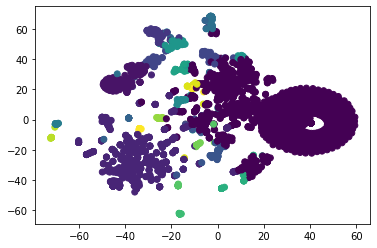

In [20]:
norm_feat_matrix = normalize(feat_matrix)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(norm_feat_matrix)
y_pred = KMeans(n_clusters=20).fit_predict(reduced_feat_matrix)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)

In [21]:
for k in range(20):
    showing_cluster(y_pred, vocab, k, showing=50)
    print('-------------\n')

Cluster 0 (2508 words):
['10', '11', '12', '13', '14', '17', '18', '193', '2nd', '3313', '350', '3rd', '44', '4th', '4x4', '5901', '5th', '6140', '6th', '76', '7th', '80', '8th', 'abject', 'able', 'about', 'aboy', 'ac', 'accessories', 'accessory', 'activia', 'ad', 'add', 'adult', 'adventure', 'advertisement', 'aeroplane', 'age', 'agree', 'aha', 'ahead', 'air', 'airborne', 'aircraft', 'airplane', 'airport', 'aisle', 'ajar', 'alarm', 'alcoholic']
-------------

Cluster 1 (257 words):
['adults', 'aeroplanes', 'airways', 'animals', 'appliances', 'articles', 'babies', 'bagels', 'bags', 'balconys', 'balloons', 'banisters', 'barrels', 'basil', 'basins', 'bats', 'beds', 'bee', 'benches', 'beverages', 'bicycles', 'bikes', 'binders', 'bins', 'birds', 'biscuits', 'blankets', 'blobs', 'boards', 'boats', 'bonnet', 'bottles', 'bowls', 'boxes', 'breads', 'brushes', 'buildings', 'bulbs', 'bulls', 'bunches', 'burgers', 'burners', 'buses', 'busses', 'cables', 'cakes', 'cameramen', 'candles', 'canisters'

### Análisis

Finalmente el cluster 4, 6 y 10 parecen estar capturando palabras de categoría del objeto target, aunque muchas ocurrencias parecen seguir viéndose en otros clusters (*pineapple* en el cluster 19 o *aeroplane* en el cluster 1).

## 5) Usando solo co ocurrencia

Repito el mismo experimento usando solo la co ocurrencia de las palabras.

Para ello voy a ver trigramas de palabras.

In [22]:
vectorizer = CountVectorizer(ngram_range=(3,3))
omatrix = vectorizer.fit_transform(questions)

Como el CountVectorizer me da ocurrencias a nivel oración y yo quiero caracterizar palabras, agrego todas las ocurrencias y luego las vectorizo contando la cantidad de ocurrencias de las palabras que la rodean.

In [23]:
# Lista de co-ocurrencias de palabras
all_occurrence = omatrix.toarray().T.sum(axis=1)

In [24]:
words = []
for feat in vectorizer.get_feature_names():
    words += feat.split(' ')
# Me deshago de los duplicados
words = set(words)
vocab = {w:{'id':i, 'context':[], 'ocurrence':[]} for i, w in enumerate(words)}
word_count = {w: 0 for w in words}
for count, feat in zip(all_occurrence, vectorizer.get_feature_names()):
    wl, w, wr = feat.split(' ')
    for c in [wl, wr]:
        if not (c in vocab[w]['context']):
            vocab[w]['context'].append(c)
            vocab[w]['ocurrence'].append(count)
        else:
            i = vocab[w]['context'].index(c)
            vocab[w]['ocurrence'][i] += count
    word_count[wl] += count
    word_count[w] += count
    word_count[wr] += count

Vectorización

In [25]:
word_ocurrence = np.array([word_count[k] for k in word_count])
keeping = np.where(word_ocurrence > 10)
relevant_context = np.asarray(list(word_count.keys()))[keeping]
len(relevant_context)

shape = (len(vocab), len(relevant_context))
feat_matrix = np.zeros(shape)

for w in tqdm(list(vocab.values())):
    i = w['id']
    context = w['context']
    ocurrence = w['ocurrence']
    for j, dep in enumerate(relevant_context):
        try:
            k = context.index(tuple(dep))
        except ValueError:
            continue
        feat_matrix[i,j] = ocurrence[k]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4941/4941 [00:21<00:00, 225.43it/s]


Empleo el mismo pipeline empleado anteriormente

/users/mmazuecos/anaconda3/envs/textmining/lib/python3.9/site-packages/sklearn/decomposition/_truncated_svd.py:205: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/users/mmazuecos/anaconda3/envs/textmining/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


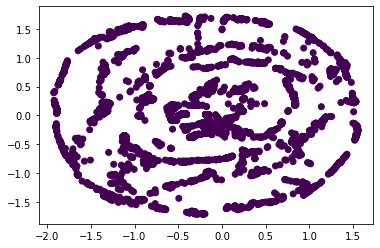

In [26]:
norm_feat_matrix = normalize(feat_matrix)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
reduced_feat_matrix = svd.fit_transform(norm_feat_matrix)
y_pred = KMeans(n_clusters=20).fit_predict(reduced_feat_matrix)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(reduced_feat_matrix)
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred)

La co ocurrencia solo genera un enorme blob indistinguible en el espacio.